# Medical Transcriptions Categorization
Freya Gray
CS39AA - Natural Language Processing
<br>
This project uses medical transcripts to try and classify the medical specialty that the transcript originated from. The dataset is from the Medical Transcriptions dataset on [Kaggle](https://www.kaggle.com/tboyle10/medicaltranscriptions). 

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import nltk
from nltk import WordNetLemmatizer, FreqDist
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/freyahexa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/freyahexa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/freyahexa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Import dataset

In [2]:
df = pd.read_csv('mtsamples.csv')
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


### Data cleanup
drop unneeded columns

In [3]:
df.drop(['Unnamed: 0','description','sample_name','keywords'], axis = 1, inplace = True)
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


Check for null transcripts and drop them

In [4]:
df.isnull().sum()

medical_specialty     0
transcription        33
dtype: int64

In [5]:
df.dropna(inplace = True)

Size of dataset after cleaning

In [6]:
df.reset_index(drop = True, inplace = True)
df.describe()

,medical_specialty,transcription
count,4966,4966
unique,40,2357
top,Surgery,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO..."
freq,1088,5


After removing null transcripts, the data set contains 4,966 transcriptions and 40 medical specialties. The transcriptions will be the observations while the medical specialties will be the targets. Tokens will be the words in a transcript.

## Exploratory Data Analysis

## Targets

In [7]:
df['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

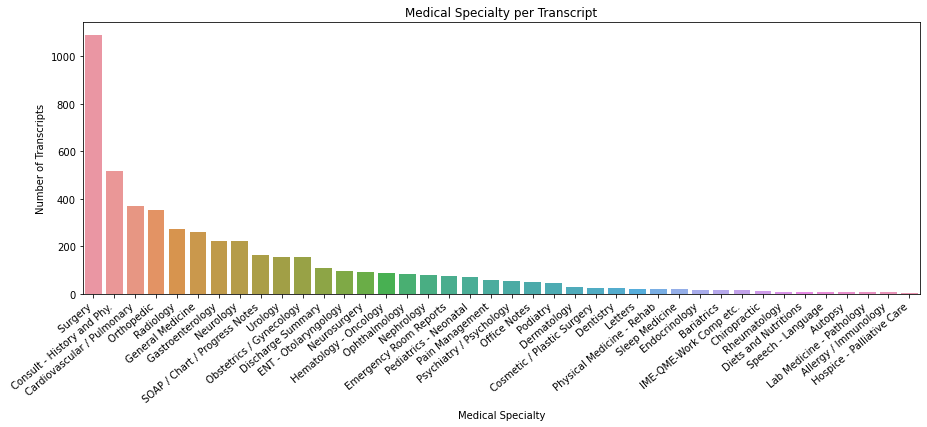

In [25]:
plt.figure(figsize=(15,5))
targets = sns.countplot(data = df, x = 'medical_specialty',order=df['medical_specialty'].value_counts().index)
targets.set_xticklabels(targets.get_xticklabels(), rotation=40, ha="right")
targets.set(xlabel = 'Medical Specialty', ylabel = 'Number of Transcripts')
targets.set_title('Medical Specialty per Transcript')
plt.show()

Around 20% of the observations are classified as surgery transcripts. Speech - Language, Autopsy, Lab Medicine - Pathology, Allergy/Immunology and Hospice - Palliative Care have less than 10 observations.

### Number of characters in each transcription

In [9]:
df['num_characters'] = df['transcription'].str.len()
df['num_characters'].head()

0    1331
1    2431
2    4422
3     495
4    1618
Name: num_characters, dtype: int64

In [10]:
df['num_characters'].describe()

count     4966.000000
mean      3052.314337
std       1994.082239
min         11.000000
25%       1608.000000
50%       2667.000000
75%       4011.000000
max      18425.000000
Name: num_characters, dtype: float64

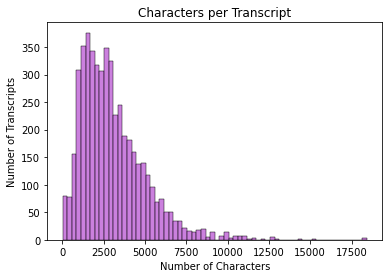

In [11]:
num_characters = sns.histplot(data = df['num_characters'], color = 'mediumorchid')
num_characters.set_title('Characters per Transcript')
num_characters.set(xlabel = 'Number of Characters', ylabel = 'Number of Transcripts')
plt.show()

The distribution for characters per transcript is skewed right. The average transcript is around 3,052 characters in length, with the largest transcript being 18,425 characters long and the shortest being 11 characters long.

### Number of words in each transcription

In [12]:
df['num_words'] = df['transcription'].apply(word_tokenize).apply(len)
df['num_words'].describe()

count    4966.000000
mean      553.022755
std       362.017929
min         3.000000
25%       289.250000
50%       485.000000
75%       731.000000
max      3489.000000
Name: num_words, dtype: float64

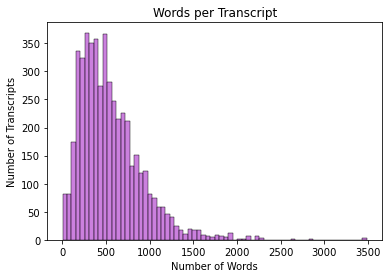

In [13]:
num_words = sns.histplot(data = df['num_words'], color = 'mediumorchid')
num_words.set_title('Words per Transcript')
num_words.set(xlabel = 'Number of Words', ylabel = 'Number of Transcripts')
plt.show()

The distribution for words per transcipt is skewed right. The average transcript is around 553 words in length, with the largest transcript being 3489 words long and the shortest being 3 words long.

### Number of sentences in each transcription

In [14]:
df['num_sentences'] = df['transcription'].apply(sent_tokenize).apply(len)
df['num_sentences'].describe()

count    4966.000000
mean       29.602698
std        20.190079
min         1.000000
25%        15.000000
50%        25.000000
75%        40.000000
max       159.000000
Name: num_sentences, dtype: float64

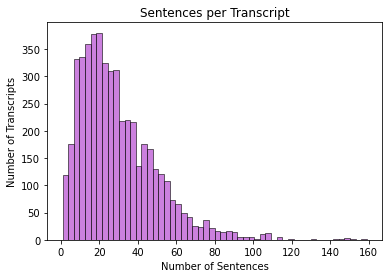

In [15]:
num_sentences = sns.histplot(data=df['num_sentences'], color = 'mediumorchid')
num_sentences.set_title('Sentences per Transcript')
num_sentences.set(xlabel = 'Number of Sentences', ylabel = 'Number of Transcripts')
plt.show()

The distribution for sentences per transcipt is skewed right. The average transcript is around 29 sentences in length, with the largest transcript being 159 sentences long and the shortest being one sentence long.

### Average word length for each transcription

In [16]:
df['avg_word_len'] = df['transcription'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
df['avg_word_len'].describe()

count    4966.000000
mean        5.635643
std         0.609934
min         4.250460
25%         5.299089
50%         5.548732
75%         5.848949
max        13.200000
Name: avg_word_len, dtype: float64

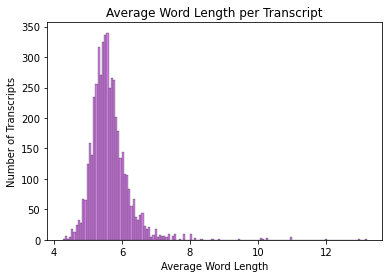

In [17]:
avg_word_len = sns.histplot(data=df['avg_word_len'], color = 'mediumorchid')
avg_word_len.set_title('Average Word Length per Transcript')
avg_word_len.set(xlabel = 'Average Word Length', ylabel = 'Number of Transcripts')
plt.show()

The distribution for average word length is skewed right. The average word is around 5 characters long, with the largest word being 13 characters long and the shortest is four characters long. 

### Stopwords in transcriptions

In [18]:
stop_words = stopwords.words("english")

In [19]:
data_strings = " ".join(df['transcription'].values)
corpus = data_strings.split()
frequent_words = FreqDist(corpus)
print(frequent_words.most_common(10))

[('the', 111618), ('and', 81694), ('was', 71687), ('of', 55866), ('to', 49796), ('a', 36527), ('with', 35257), ('The', 34210), ('in', 31058), ('is', 26278)]


The most frequently occuring words in all transcripts are stop words

### N-grams

In [20]:
def preprocess_text(text):
    tokeniser = RegexpTokenizer(r'[A-Za-z]{2,}')
    tokens = tokeniser.tokenize(text)

    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]

    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stop_words]
    return keywords

def get_frequent_ngram(corpus, ngram, n=20):
    # Preprocess each document
    documents = [preprocess_text(document) for document in corpus]
    
    # Find ngrams per document
    n_grams = [list(ngrams(document, ngram)) for document in documents]
    
    # Find frequency of ngrams
    n_grams_flattened = [item for sublist in n_grams for item in sublist]
    freq_dist = FreqDist(n_grams_flattened)
    top_freq = freq_dist.most_common(n)
    return pd.DataFrame(top_freq, columns=["ngram", "count"])
#Source: Towards Data Science

### Most Common Words

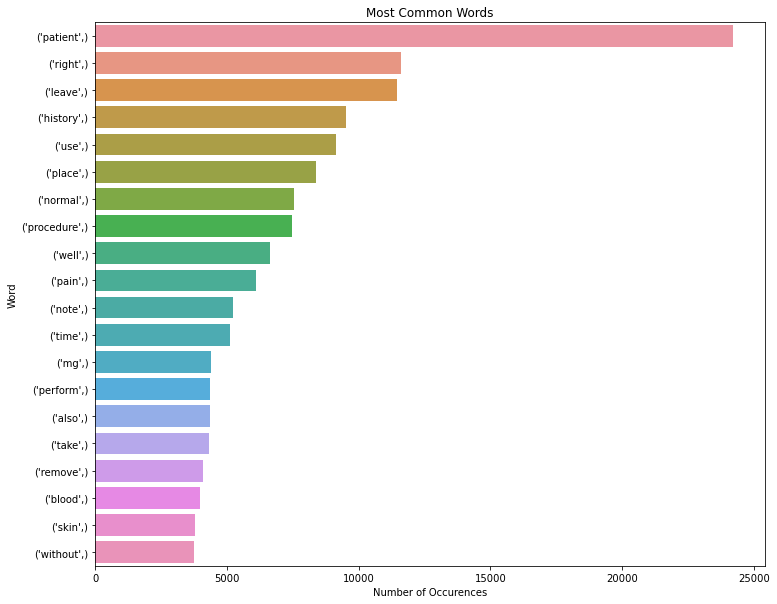

In [21]:
plt.figure(figsize=(12,10))
most_common_words = sns.barplot(x="count", y="ngram", data=get_frequent_ngram(df['transcription'], 1))
most_common_words.set_title('Most Common Words')
most_common_words.set(xlabel = 'Number of Occurences', ylabel = 'Word')
plt.show()

### Most Common Bigrams

[Text(0.5, 0, 'Number of Occurences'), Text(0, 0.5, 'Bigram')]

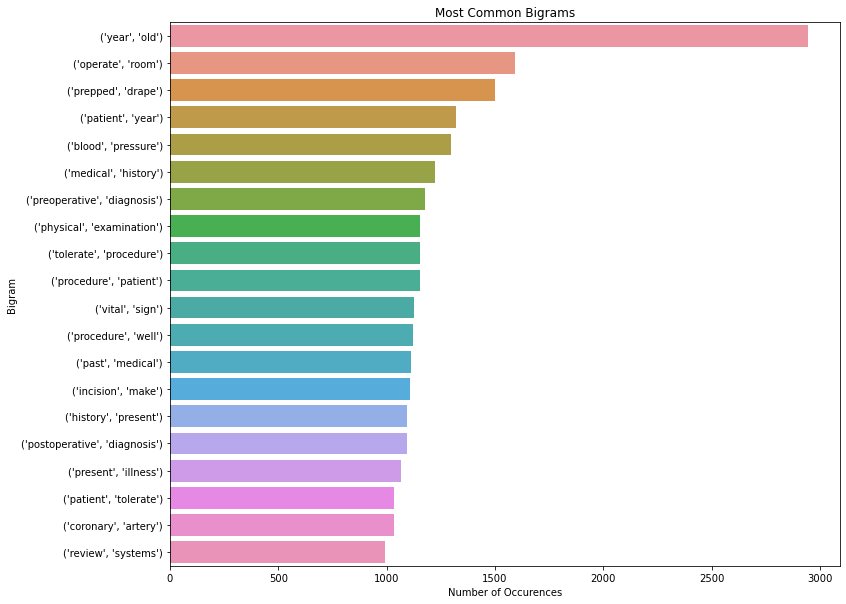

In [22]:
plt.figure(figsize=(12,10))
most_common_words = sns.barplot(x="count", y="ngram", data=get_frequent_ngram(df['transcription'], 2))
most_common_words.set_title('Most Common Bigrams')
most_common_words.set(xlabel = 'Number of Occurences', ylabel = 'Bigram')

### Most Common Trigrams

[Text(0.5, 0, 'Number of Occurences'), Text(0, 0.5, 'Trigram')]

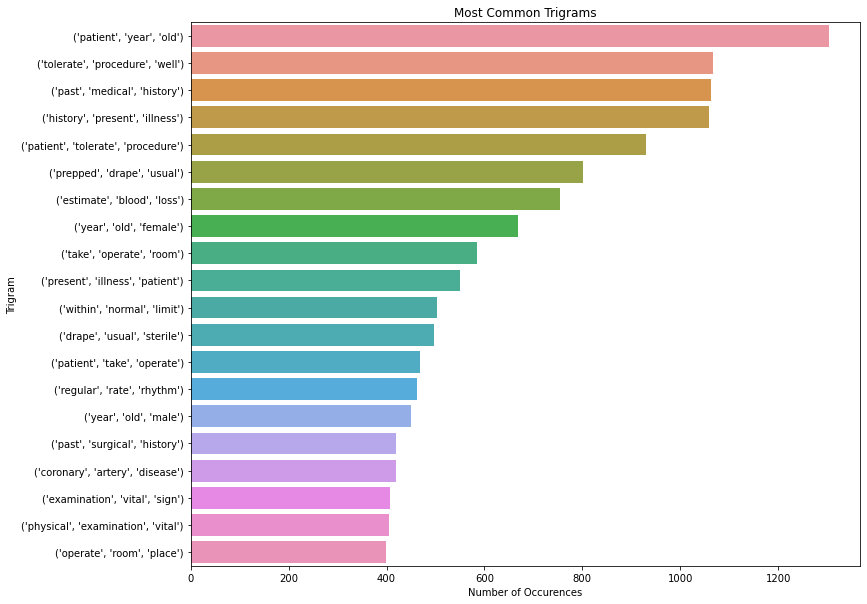

In [23]:
plt.figure(figsize=(12,10))
most_common_words = sns.barplot(x="count", y="ngram", data=get_frequent_ngram(df['transcription'], 3))
most_common_words.set_title('Most Common Trigrams')
most_common_words.set(xlabel = 'Number of Occurences', ylabel = 'Trigram')

## Wordcloud 

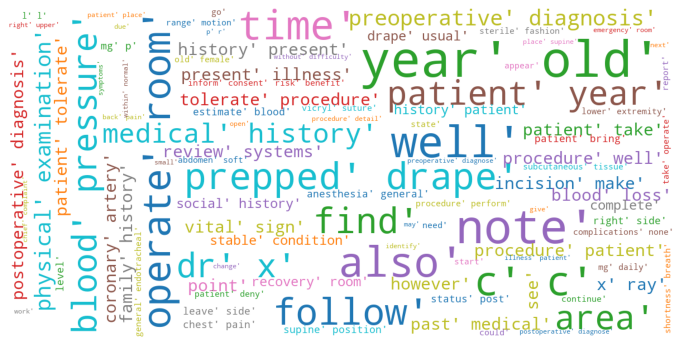

In [24]:
tokeniser = RegexpTokenizer("[A-Za-z]+")
tokens = tokeniser.tokenize(data_strings)
lemmatiser = WordNetLemmatizer()
tokens_norm = [lemmatiser.lemmatize(t.lower(), "v") for t in tokens]
tokens_clean = [t for t in tokens_norm if t not in stop_words]

wordcloud = WordCloud(
    background_color='white',
    stopwords=stop_words,
    colormap = 'tab10',
    max_words=100,
    max_font_size=30,
    scale=3,
    random_state=1)

wordcloud=wordcloud.generate(str(tokens_clean))

fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')

plt.imshow(wordcloud)
plt.show()


# Sources

**Dataset:**<br/>
[Kaggle](https://www.kaggle.com/tboyle10/medicaltranscriptions)

**Guides for exploratory data analysis:**<br/>
[Towards Data Science](https://towardsdatascience.com/exploratory-text-analysis-in-python-8cf42b758d9e) <br/>
[Neptune](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools)
